# Flight Delay Analysis

In [1]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

Flight delays and cancellations are typical problems all of us face when traveling. The airports and airline industry try to minimize the impact on the customers and improve their experience. On the other the airline industry also optimizes the flights to fly through their network of cities. For example, a flight from Seattle flies to Chicago, and then further is scheduled to fly from Chicago to New York City. As a result of this efficient utilization of the flights, a popular belief among travelers is that flight delays or cancellations happen more often as the day progresses. Though it seems intuitive, we as data scientists will always look at data to check our intuition.

The U.S. Department of Transportation’s (DOT) [Buereau of Transportation Statistics](https://www.bts.gov/) tracks the performance of domestic flights operated by large airline carriers.
In this project we will work with [dataset](https://www.kaggle.com/usdot/flight-delays) compiled by Kaggle providing summary information on the number of on-time, delayed, canceled, and diverted flights published by DOT’s montly Air Travel Consumer Report for the year 2015.!

## 0. Data Preparation

In [1]:
# Starter code

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
# The following statements should get the three data files loaded as DataFrames. 

airlines = pd.read_csv("../resource/asnlib/publicdata/airlines.csv")
airports = pd.read_csv("../resource/asnlib/publicdata/airports.csv")
flights  = pd.read_csv("https://www3.nd.edu/~jng2/flights_20_perc.csv") 
# the flights file is ~140mb so will take a few seconds to load

In [2]:
# make an copy of the data to avoid reloading
flights1 = flights.copy()

# combine year-month-day
import datetime
flights1['Date'] = pd.to_datetime(flights1[['YEAR','MONTH','DAY']], format='%Y%b%d')

# set the eariler/later period label
flights1.loc[flights1['SCHEDULED_DEPARTURE'] >= 1200, 'DE_Period'] = 'Later'
flights1.loc[flights1['SCHEDULED_DEPARTURE'] < 1200, 'DE_Period'] = 'Earlier'
flights1.loc[flights1['SCHEDULED_ARRIVAL'] > 1200, 'AR_Period'] = 'Later'
flights1.loc[flights1['SCHEDULED_ARRIVAL'] <= 1200, 'AR_Period'] = 'Earlier'
flights1.loc[flights1['DEPARTURE_DELAY'] > 0, 'Departure_Delayed'] = 1
flights1.loc[flights1['DEPARTURE_DELAY'] <= 0, 'Departure_Delayed'] = 0
flights1.loc[flights1['ARRIVAL_DELAY'] > 0, 'Arrival_Delayed'] = 1
flights1.loc[flights1['ARRIVAL_DELAY'] <= 0, 'Arrival_Delayed'] = 0
flights1['Depart_Hour']=flights1['SCHEDULED_DEPARTURE'].astype(str).str[-4:-2].replace('', '0').astype(int)
flights1['Arrival_Hour']=flights1['SCHEDULED_ARRIVAL'].astype(str).str[-4:-2].replace('', '0').astype(int)

I conducted some data manipulation steps and got a few new columns in my dataset.
- **Date**: the actual date of the flight.
- **DE_Period**: For simplification, I used noon (12PM) as the time cutoff. Any departure time before 12PM is considered earlier in the day and assigned a <font color='blue'><strong>'Earlier'</strong></font> label while any departure time after 12PM is considered later in the day and assigned a <font color='goldenrod'><strong>'Later'</strong></font> label.
- **AR_Period**: As the DE_Period column, any arrival time before 12PM is considered earlier in the day and assigned a <font color='blue'><strong>'Earlier'</strong></font> label while any arrival time after 12PM is considered later in the day and assigned a <font color='goldenrod'><strong>'Later'</strong></font> label.
- **Departure_Delayed**: If the actual departure time is later than the scheduled departure time, it is tagged as 1, otherwise 0.
- **Arrival_Delayed**: If the actual arrival time is later than the scheduled arrival time, it is tagged as 1, otherwise 0.
- **Depart_Hour**: The hour extracted from the scheduled departure time.
- **Arrival_Hour**: The hour extracted from the scheduled arrival time.

## 1. Do flight delays happen more often later in the day compared to earlier in the day?

### 1.1. Overall Flight Delays (Absolute & Relative)

In [3]:
flights_de = flights1.groupby('DE_Period').agg(
    {'Departure_Delayed':'sum','FLIGHT_NUMBER':'count'}).rename(
    columns={'Departure_Delayed':'Delay','FLIGHT_NUMBER':'Total'})
flights_de['Percentage']=flights_de['Delay']/flights_de['Total']

flights_ar = flights1.groupby('AR_Period').agg(
    {'Arrival_Delayed':'sum','FLIGHT_NUMBER':'count'}).rename(
    columns={'Arrival_Delayed':'Delay','FLIGHT_NUMBER':'Total'})
flights_ar['Percentage']=flights_ar['Delay']/flights_ar['Total']

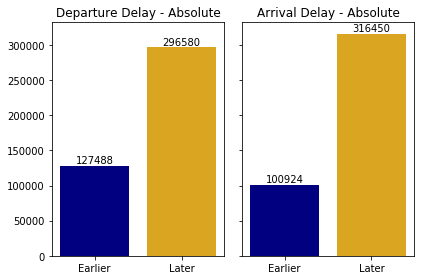

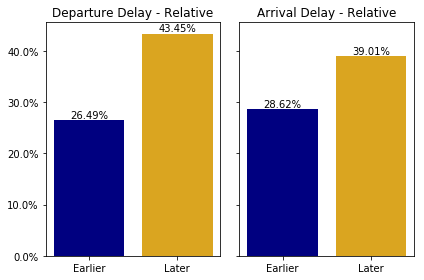

In [47]:
figure, axes = plt.subplots(1,2,sharey=True)
axes[0].bar(flights_de.index, flights_de['Delay'],color=['navy','goldenrod'])
axes[0].set_title('Departure Delay - Absolute')
axes[1].bar(flights_ar.index, flights_ar['Delay'],color=['navy','goldenrod'])
axes[1].set_title('Arrival Delay - Absolute')
plt.tight_layout()

for a,b in zip(flights_de.index,flights_de['Delay']):
    axes[0].text(a, b+1000,'%.0f' % b, ha='center', va= 'bottom',fontsize=10)
for a,b in zip(flights_ar.index,flights_ar['Delay']):
    axes[1].text(a, b+1000,'%.0f' % b, ha='center', va= 'bottom',fontsize=10)
plt.tight_layout()

figure, axes = plt.subplots(1,2,sharey=True)
axes[0].bar(flights_de.index, flights_de['Percentage'],color=['navy','goldenrod'])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes[0].set_title('Departure Delay - Relative')
axes[1].bar(flights_ar.index, flights_ar['Percentage'],color=['navy','goldenrod'])
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes[1].set_title('Arrival Delay - Relative')

for a,b in zip(flights_de.index,flights_de['Percentage']):
    axes[0].text(a, b+0.001,"{:.2%}".format(b), ha='center', va= 'bottom',fontsize=10)
for a,b in zip(flights_ar.index,flights_ar['Percentage']):
    axes[1].text(a, b+0.001,  "{:.2%}".format(b), ha='center', va= 'bottom',fontsize=10)
plt.tight_layout()

I plotted for both the absolute and relative numbers because I think the low level in absolute number may be caused by the low level in the total number of flights. We can see the gaps become narrower in the relative visuals than in the abusolute ones, which aligns with our assumption. Relative delay frequency and rate are more unbiased metrics for us to look at. 

To be more detailed, I checked the delays in both departures and arrivals. 

- We can see that there are more flight delays happen later in the day than earlier in the day. 43.54% of flights were delayed during the departure for all the flights scheduled to depart later in the day (after 12PM), while only 26.6% of all the flights scheduled to depart earlier in the day got delayed. The comparison result is the same with arrival delay - **delays do happen more often later in the day!** If you don't want to get delayed, please choose a morning flight.

- Compared to the arrival delay, the gap in the departure delay percentage are larger. That is to say, you should consider more carefully to choose your flight departure time instead of the arrival one since your choice would make cause bigger difference in the possibility that you would get delayed. 

### 1.2. Flight Delay Rates by Hour

[<matplotlib.axis.XTick object at 0x7f551fb20400>, <matplotlib.axis.XTick object at 0x7f551f601b70>, <matplotlib.axis.XTick object at 0x7f551f601550>, <matplotlib.axis.XTick object at 0x7f551fa58358>, <matplotlib.axis.XTick object at 0x7f551fa50a58>, <matplotlib.axis.XTick object at 0x7f553cab0be0>, <matplotlib.axis.XTick object at 0x7f551fb4c0f0>, <matplotlib.axis.XTick object at 0x7f551fb4c588>, <matplotlib.axis.XTick object at 0x7f551fb4ca90>, <matplotlib.axis.XTick object at 0x7f551fb4ce80>, <matplotlib.axis.XTick object at 0x7f553ca97208>, <matplotlib.axis.XTick object at 0x7f551fb4d160>, <matplotlib.axis.XTick object at 0x7f551fb4d630>, <matplotlib.axis.XTick object at 0x7f551fb4db38>, <matplotlib.axis.XTick object at 0x7f553cb080f0>, <matplotlib.axis.XTick object at 0x7f553cb08588>, <matplotlib.axis.XTick object at 0x7f553cb08a90>, <matplotlib.axis.XTick object at 0x7f553cb08e80>, <matplotlib.axis.XTick object at 0x7f553cb08f60>, <matplotlib.axis.XTick object at 0x7f553cb08128>,

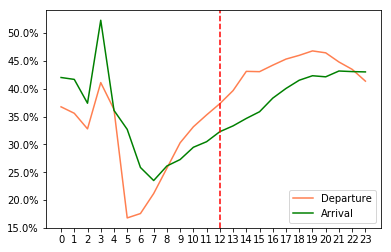

In [40]:
flights_de_hour = flights1.groupby('Depart_Hour').agg(
    {'Departure_Delayed':'sum','FLIGHT_NUMBER':'count'}).rename(
    columns={'Departure_Delayed':'Delay','FLIGHT_NUMBER':'Total'})
flights_de_hour['Percentage']=flights_de_hour['Delay']/flights_de_hour['Total']

flights_ar_hour = flights1.groupby('Arrival_Hour').agg(
    {'Arrival_Delayed':'sum','FLIGHT_NUMBER':'count'}).rename(
    columns={'Arrival_Delayed':'Delay','FLIGHT_NUMBER':'Total'})
flights_ar_hour['Percentage']=flights_ar_hour['Delay']/flights_ar_hour['Total']

figure, axes = plt.subplots()
axes.plot(flights_de_hour.index,flights_de_hour['Percentage'],label='Departure',color='coral')
axes.plot(flights_ar_hour.index,flights_ar_hour['Percentage'],label='Arrival',color='green')
axes.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes.axvline(x=12, ymin=0, ymax=1,color="red",linestyle='--')
axes.legend(ncol=1, loc='lower right')
axes.set_xticks(np.arange(min(flights_ar_hour.index), max(flights_ar_hour.index)+1, 1.0))

To be more deatiled, I broke down the delay percentage into hours. We can see that departure delays rate begins to increase starting from 5AM till 7PM before another decline. As for the arrival delays rate, it starts at a quite high point and gradually declines till it reaches its lowest point at around 7AM. Then, it increases as time progresses in the day.

- **Earlier in the day**: The trend line before 12PM is hard to get a consistent result, but we notice that the departure percentage at around 5-6AM is really low. It is possibly resulted from the small number of total flights.
- **Later in the day**: We can see that flights have a higher chance to get delayed during departure than arrvial after 12PM. 

**Conclusion for Question1:** 

The flight delays do happen more often later in the day compared to earlier in the day.

## 2. Does the response to Claim 1 depend on the month of the year?

### 2.1. Flight Delay Rates by Month

In [6]:
flights_de_month = flights1.groupby(['MONTH','DE_Period'],as_index=False).agg(
    {'Departure_Delayed':'sum','FLIGHT_NUMBER':'count'}).rename(
    columns={'Departure_Delayed':'Delay','FLIGHT_NUMBER':'Total'})
flights_de_month['Percentage']=flights_de_month['Delay']/flights_de_month['Total']

flights_ar_month = flights1.groupby(['MONTH','AR_Period'],as_index=False).agg(
    {'Arrival_Delayed':'sum','FLIGHT_NUMBER':'count'}).rename(
    columns={'Arrival_Delayed':'Delay','FLIGHT_NUMBER':'Total'})
flights_ar_month['Percentage']=flights_ar_month['Delay']/flights_ar_month['Total']

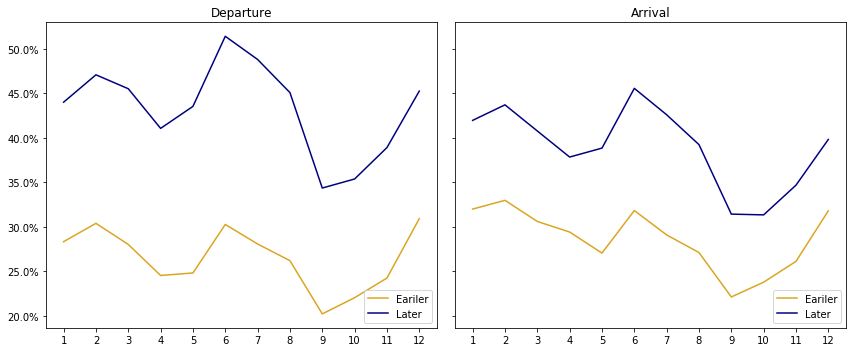

In [46]:
figure, axes = plt.subplots(1,2,sharey=True,figsize=(12,5))
axes[0].plot(flights_de_month[flights_de_month['DE_Period']=='Earlier']['MONTH'], flights_de_month[flights_de_month['DE_Period']=='Earlier']['Percentage'],label='Eariler',color='goldenrod')
axes[0].plot(flights_de_month[flights_de_month['DE_Period']=='Later']['MONTH'], flights_de_month[flights_de_month['DE_Period']=='Later']['Percentage'],label='Later',color='navy')
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes[0].legend(ncol=1, loc='lower right')
axes[0].set_xticks(np.arange(min(flights_de_month[flights_de_month['DE_Period']=='Earlier']['MONTH']), max(flights_de_month[flights_de_month['DE_Period']=='Earlier']['MONTH'])+1, 1.0))
axes[0].set_title('Departure')

axes[1].plot(flights_ar_month[flights_ar_month['AR_Period']=='Earlier']['MONTH'], flights_ar_month[flights_ar_month['AR_Period']=='Earlier']['Percentage'],label='Eariler',color='goldenrod')
axes[1].plot(flights_ar_month[flights_ar_month['AR_Period']=='Later']['MONTH'], flights_ar_month[flights_ar_month['AR_Period']=='Later']['Percentage'],label='Later',color='navy')
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes[1].legend(ncol=1, loc='lower right')
axes[1].set_xticks(np.arange(min(flights_ar_month[flights_ar_month['AR_Period']=='Earlier']['MONTH']), max(flights_ar_month[flights_ar_month['AR_Period']=='Earlier']['MONTH'])+1, 1.0))
axes[1].set_title('Arrival')
plt.tight_layout()

- From the visual above, we can easily see that no matter in departure or arrival delays, the later line is always above the eariler one in each month. That is to say, **the flight delays do happen more often later in the day compared to earlier in the day across different months.**

- Another take away from the visual is that the delays seem to have a *seasonal trend*. The delay rate tend to be higher in summer and winter than in spring and autumn. I believe it may be resulted from the fact severe weathers show up more frequently in summer and winter. Also, the student vacations may contribute to the situation as well.

### 2.2. Flight Delay Rates by Month and Hour

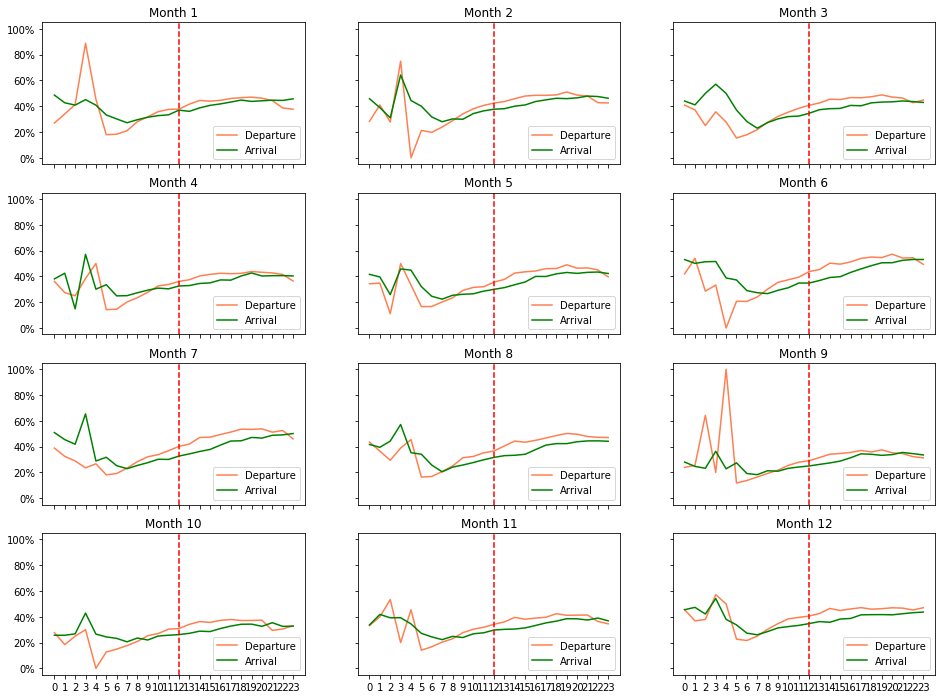

In [41]:
flights_de_month_hour = flights1.groupby(['MONTH','Depart_Hour'],as_index=False).agg(
    {'Departure_Delayed':'sum','FLIGHT_NUMBER':'count'}).rename(
    columns={'Departure_Delayed':'Delay','FLIGHT_NUMBER':'Total'})
flights_de_month_hour['Percentage']=flights_de_month_hour['Delay']/flights_de_month_hour['Total']

flights_ar_month_hour = flights1.groupby(['MONTH','Arrival_Hour'],as_index=False).agg(
    {'Arrival_Delayed':'sum','FLIGHT_NUMBER':'count'}).rename(
    columns={'Arrival_Delayed':'Delay','FLIGHT_NUMBER':'Total'})
flights_ar_month_hour['Percentage']=flights_ar_month_hour['Delay']/flights_ar_month_hour['Total']

figure, axes = plt.subplots(4,3,sharex=True,sharey=True,figsize=(16,12))
i = 1
for j in range(0,4):
    for k in range(0,3):
        axes[j,k].plot(flights_de_month_hour[flights_de_month_hour['MONTH']== i]['Depart_Hour'],flights_de_month_hour[flights_de_month_hour['MONTH']== i]['Percentage'],label='Departure',color='coral')
        axes[j,k].plot(flights_ar_month_hour[flights_ar_month_hour['MONTH']== i]['Arrival_Hour'],flights_ar_month_hour[flights_ar_month_hour['MONTH']== i]['Percentage'],label='Arrival',color='green')
        axes[j,k].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        axes[j,k].axvline(x=12, ymin=0, ymax=1,color="red",linestyle='--')
        axes[j,k].legend(ncol=1, loc='lower right')
        axes[j,k].set_title('Month ' + str(i))
        axes[j,k].set_xticks(np.arange(min(flights_ar_month_hour['Arrival_Hour']), max(flights_ar_month_hour['Arrival_Hour'])+1, 1.0))
        i += 1

To be more detailed, I also plotted the departure and arrival delay trend line in different hours in different months. A red reference line has been added to each visual to divide a day as two parts - **Earlier** and **Later**.

- **Later in the day**: We can see that in every month, departure delay rate is mostly higher than the arrival one after 12PM. 

- **Earlier in the day**: However, the case is quite different before 12PM in each month. There are some months that have significantly high departure delay rate in the morning, such as September. Also, there are some months with low departure delay rate in the morning, such as June. Delay-sensitive customers can avoid hours and months with high delay rates based on the above visualization.

**Conclusion for Question2:** 

The fact that flight delays happen more often later in the day compared to earlier in the day is consistent across all the months.

## 3. Does the response to Claim 1 depend on the airline? Which airlines have this phenomenon more pronounced and less pronounced?

In my definition, I want to explore that for each airline, whether earlier or later in a day would have higher delay rate. Also, I want to which airline would have larger gap between the delay rates in the morning and afternoon. 

Therefore, I firstly want to create a **side-to-side bar chart**, in which two different bars are showing the delay rates in the earlier of the day and in the later of the day respectively. With these two bars, we can easily compare the difference in delay rates across different airlines. Then I want to make a **deviation line graph**. The values of the line shows the gap between the two bars in one certain airline. If the value is high, it means that this airline company has larger delay rate gap.

Then, I also divide the delays into departure delays and the arrival ones.

In [9]:
flights2=pd.merge(flights1,airlines,how='left',left_on='AIRLINE',right_on='IATA_CODE')

flights_de_airline = flights2.groupby(['AIRLINE_y','DE_Period'],as_index=False).agg(
    {'Departure_Delayed':'sum','FLIGHT_NUMBER':'count'}).rename(
    columns={'Departure_Delayed':'Delay','FLIGHT_NUMBER':'Total'})
flights_de_airline['Percentage']=flights_de_airline['Delay']/flights_de_airline['Total']

# deviation
flights_de_airline_pivot = flights_de_airline.pivot(index='AIRLINE_y', columns='DE_Period', values='Percentage')
flights_de_airline_pivot['deviation'] = flights_de_airline_pivot['Later'] - flights_de_airline_pivot['Earlier']
flights_de_airline=pd.merge(flights_de_airline,flights_de_airline_pivot,how='left',left_on='AIRLINE_y',right_on='AIRLINE_y')

flights_ar_airline = flights2.groupby(['AIRLINE_y','AR_Period'],as_index=False).agg(
    {'Arrival_Delayed':'sum','FLIGHT_NUMBER':'count'}).rename(
    columns={'Arrival_Delayed':'Delay','FLIGHT_NUMBER':'Total'})
flights_ar_airline['Percentage']=flights_ar_airline['Delay']/flights_ar_airline['Total']

# deviation
flights_ar_airline_pivot = flights_ar_airline.pivot(index='AIRLINE_y', columns='AR_Period', values='Percentage')
flights_ar_airline_pivot['deviation'] = flights_ar_airline_pivot['Later'] - flights_ar_airline_pivot['Earlier']
flights_ar_airline=pd.merge(flights_ar_airline,flights_ar_airline_pivot,how='left',left_on='AIRLINE_y',right_on='AIRLINE_y')

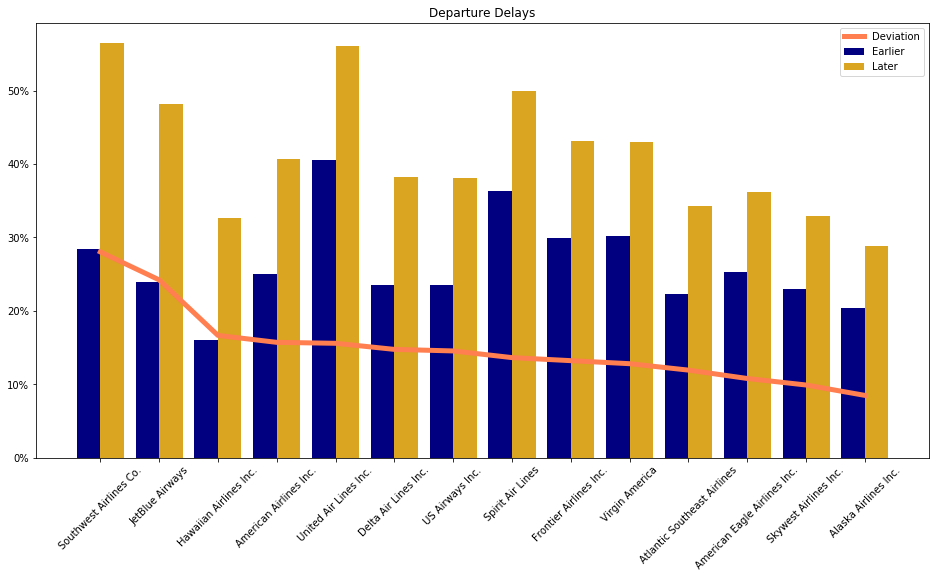

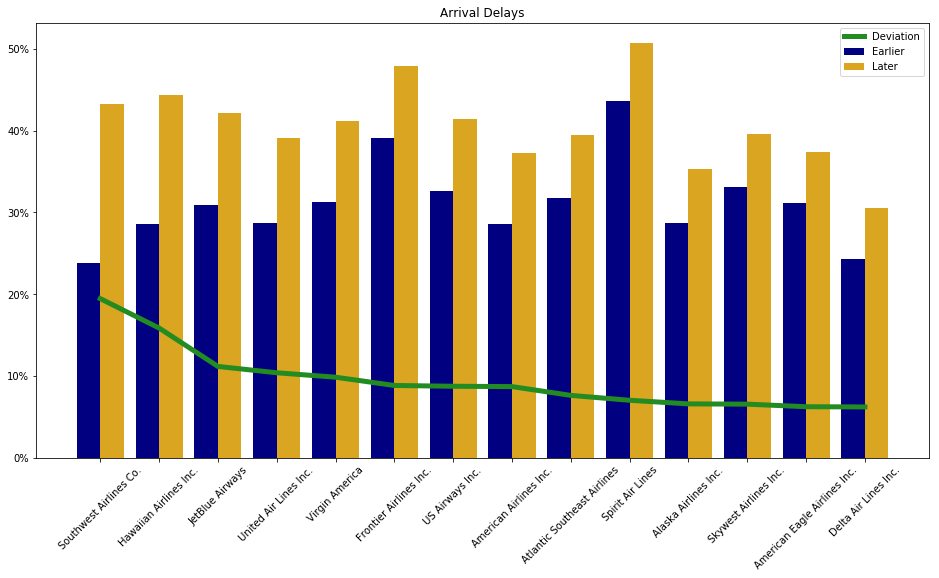

In [43]:
indices = np.arange(len(flights_de_airline[flights_de_airline['DE_Period']=='Earlier']['Percentage']))
figure, axes = plt.subplots(figsize=(16,8))
axes.bar(pd.Series(indices-.2),flights_de_airline[flights_de_airline['DE_Period']=='Earlier'].sort_values('deviation',ascending = False)['Percentage'],width=.4,color='navy',label='Earlier')
axes.bar(pd.Series(indices+.2),flights_de_airline[flights_de_airline['DE_Period']=='Later'].sort_values('deviation',ascending = False)['Percentage'],width=.4,color='goldenrod',label='Later')
plt.xticks(indices,flights_de_airline[flights_de_airline['DE_Period']=='Later'].sort_values('deviation',ascending = False)['AIRLINE_y'])
plt.xticks(rotation=45)

axes.plot(pd.Series(indices),flights_de_airline_pivot.sort_values('deviation',ascending = False)['deviation'],color='coral', linewidth=5,label='Deviation')
axes.legend(ncol=1, loc='upper right')
axes.set_title('Departure Delays')
axes.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# arrival
indices = np.arange(len(flights_ar_airline[flights_ar_airline['AR_Period']=='Earlier']['Percentage']))
figure, axes = plt.subplots(figsize=(16,8))
axes.bar(pd.Series(indices-.2),flights_ar_airline[flights_ar_airline['AR_Period']=='Earlier'].sort_values('deviation',ascending = False)['Percentage'],width=.4,color='navy',label='Earlier')
axes.bar(pd.Series(indices+.2),flights_ar_airline[flights_ar_airline['AR_Period']=='Later'].sort_values('deviation',ascending = False)['Percentage'],width=.4,color='goldenrod',label='Later')
plt.xticks(indices,flights_ar_airline[flights_ar_airline['AR_Period']=='Later'].sort_values('deviation',ascending = False)['AIRLINE_y'])
plt.xticks(rotation=45)

axes.plot(pd.Series(indices),flights_ar_airline_pivot.sort_values('deviation',ascending = False)['deviation'],color='forestgreen', linewidth=5,label='Deviation')
axes.legend(ncol=1, loc='upper right')
axes.set_title('Arrival Delays')
axes.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In the **side-to-side bar chart**, the blue bar represents delay rates in the earlier of the day and the yellow one represents delay rates in the later of the day. With these two bars, we can easily compare the difference in delay rates across different airlines. In the **deviation line graph**. The values of the line shows the gap between the two bars in one certain airline. If the value is high, it means that this airline company has larger delay rate gap between later in the day and earlier in the day. Also, I ranked the airlines based on the gap value for better insights.

- From the visual, we can see that Southwest Airlines Co., Hawaiian Airlines Inc. and JetBlue Airways are very outstanding among all the airlines no matter for the departure or arrival delays. If you plan to fly with these three company, you'd better to choose a morning flight since the flights of these airlines in the later of the day are much more likely to be delayed than the morning ones.

- Alaska Airlines Inc has the lowest gap in terms of the departure delays while the Delta AirLines Inc. has the lowest gap in terms of the arrival delays. That is to say, when you are flying with these two airlines, choices between morning and afternoon would have least different delay rates.

- We also find that Spirit Airlines has very high arrival delay rates (over 40%) in all days. In addition, although the gap is not obvious, United Airlines Inc. has very high departure delay rates in both earlier and later of the day. These two companies may need to pay some attention to the delay problem to improve themselves.

**Conclusion for Question3:** 

The fact that flight delays happen more often later in the day compared to earlier in the day is consistent across all the airlines. It does not depend on the airlines.

- The *Southwest Airlines Co.*, *Hawaiian Airlines Inc*. and *JetBlue Airways* are more pronounced, among which the **Southwest Airlines Company** is the the most pronounced one. 

- In addition, **Alaska Airlines Inc**. is the least pronounced airline in terms of the <font color='coral'><strong>departure</strong></font> delays while the **Delta AirLines Inc.** is the least pronounced one in terms of the <font color='green'><strong>arrival</strong></font> delays. 

## 4. Do flight cancellation happen more often later in the day than earlier in the day?

Based on my Analysis on Question #1, relative metrics are more unbiased and reliable than the absolute ones because they would not be affected by the total number of flights. Therefore, as for this question, I also choose to use the relative metric - **flight cancellation rate**.

I used the *scheduled departure time* to divide the <font color='blue'><strong>Earlier</strong></font> and <font color='goldenrod'><strong>Later</strong></font>. I did not include the arrival time anymore since the flight has been cancelled and the arrival time may be less important for a cancelled flight.

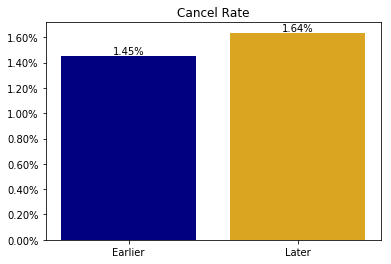

In [48]:
flights_cancel = flights1.groupby(['DE_Period'],as_index=False).agg(
    {'CANCELLED':'sum','FLIGHT_NUMBER':'count'}).rename(
    columns={'CANCELLED':'Cancelled','FLIGHT_NUMBER':'Total'})
flights_cancel['Percentage']=flights_cancel['Cancelled']/flights_cancel['Total']

figure, axes = plt.subplots()
axes.bar(flights_cancel['DE_Period'], flights_cancel['Percentage'],color=['navy','goldenrod'])
axes.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes.set_title('Cancel Rate')
for a,b in zip(flights_cancel['DE_Period'], flights_cancel['Percentage']):
    axes.text(a, b+0.000001,"{:.2%}".format(b), ha='center', va= 'bottom',fontsize=10)

All the cancellation happen after 12PM takes 1.64% proportion of all the flights in that period while cancellation before 12PM only takes 1.45% of all the flights in that period. That is to say, generally, there would be higher possibility for us to experience flight cancellation in the later of the day than in the earlier of the day.

**Conclusion for Question4:** 

Flight cancellation do happen more often later in the day than earlier in the day. 

## 5. Does the response to Claim 4 depend on the month of the year and on the airline?

### 5.1. Flight Cancellation Rate by Month

[<matplotlib.axis.XTick object at 0x7f551ba35b38>, <matplotlib.axis.XTick object at 0x7f551ba35470>, <matplotlib.axis.XTick object at 0x7f551ba35358>, <matplotlib.axis.XTick object at 0x7f551b9ed470>, <matplotlib.axis.XTick object at 0x7f551b9ed940>, <matplotlib.axis.XTick object at 0x7f551b9ede10>, <matplotlib.axis.XTick object at 0x7f551b9f4320>, <matplotlib.axis.XTick object at 0x7f551b9f47f0>, <matplotlib.axis.XTick object at 0x7f551b9f4cc0>, <matplotlib.axis.XTick object at 0x7f551b9fd208>, <matplotlib.axis.XTick object at 0x7f551b9f4668>, <matplotlib.axis.XTick object at 0x7f551b9ed2b0>]

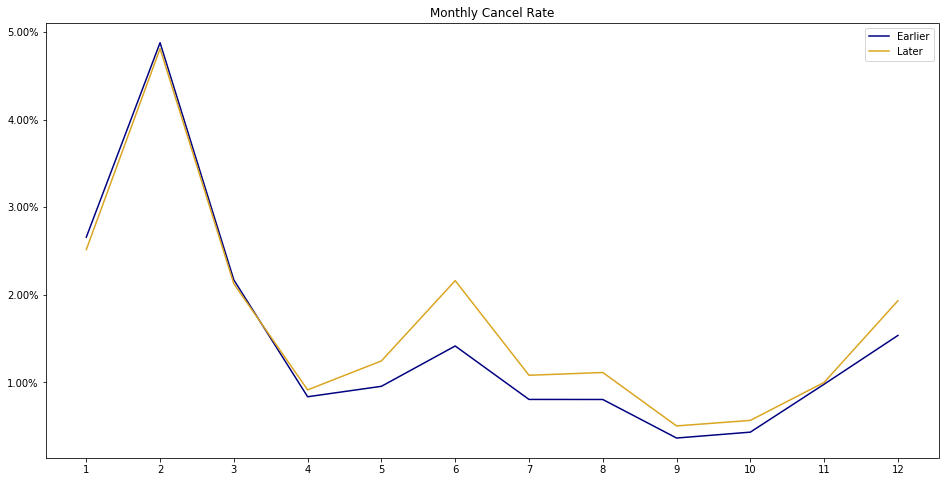

In [49]:
flights_cancel_month = flights1.groupby(['MONTH','DE_Period'],as_index=False).agg(
    {'CANCELLED':'sum','FLIGHT_NUMBER':'count'}).rename(
    columns={'CANCELLED':'Cancelled','FLIGHT_NUMBER':'Total'})
flights_cancel_month['Percentage']=flights_cancel_month['Cancelled']/flights_cancel_month['Total']

figure, axes = plt.subplots(figsize=(16,8))
axes.plot(flights_cancel_month[flights_cancel_month['DE_Period']=='Earlier']['MONTH'], flights_cancel_month[flights_cancel_month['DE_Period']=='Earlier']['Percentage'],label='Earlier',color='navy')
axes.plot(flights_cancel_month[flights_cancel_month['DE_Period']=='Later']['MONTH'], flights_cancel_month[flights_cancel_month['DE_Period']=='Later']['Percentage'],label='Later',color='goldenrod')
axes.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes.set_title('Monthly Cancel Rate')
axes.legend(ncol=1, loc='upper right')
axes.set_xticks(np.arange(min(flights_cancel_month[flights_cancel_month['DE_Period']=='Earlier']['MONTH']), max(flights_cancel_month[flights_cancel_month['DE_Period']=='Earlier']['MONTH'])+1, 1.0))

From the visual above, we can see that **the response to Claim 4 does depend on the month of the year. ** Two lines in the graph have some overlaps, which means that sometimes the flight cancellations happen more in the earlier of the day (such as February) and sometimes more in the later of the day (such as June).

There are some additional take-aways:
- The highest cancel rate is in February for both earlier and later in a day. Although the difference within is not obvious, people should be aware that the overall cancellation rate in February is much higher than in other months.
- From January to April, the gap between two lines is very small. However, the gap becomes very large during May to October, with the largest gap in June. In other words, in June, people should choose a flight in the earlier of the day to avoid cancellations.

### 5.2. Flight Cancellation Rate by Airline

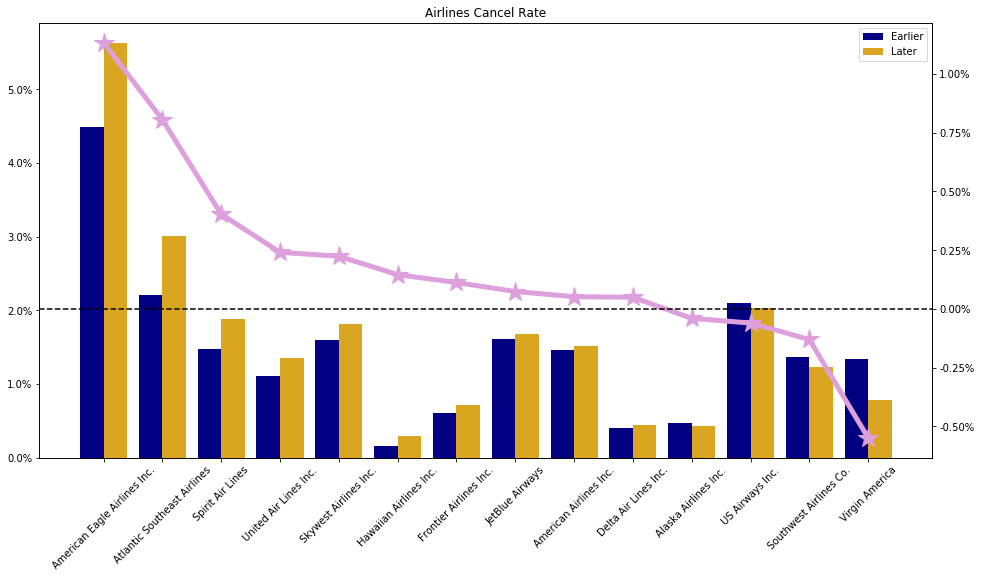

In [51]:
flights_cancel_airline = flights2.groupby(['AIRLINE_y','DE_Period'],as_index=False).agg(
    {'CANCELLED':'sum','FLIGHT_NUMBER':'count'}).rename(
    columns={'CANCELLED':'Cancelled','FLIGHT_NUMBER':'Total'})
flights_cancel_airline['Percentage']=flights_cancel_airline['Cancelled']/flights_cancel_airline['Total']

# deviation
flights_cancel_airline_pivot = flights_cancel_airline.pivot(index='AIRLINE_y', columns='DE_Period', values='Percentage')
flights_cancel_airline_pivot['deviation'] = flights_cancel_airline_pivot['Later'] - flights_cancel_airline_pivot['Earlier']
flights_cancel_airline=pd.merge(flights_cancel_airline,flights_cancel_airline_pivot,how='left',left_on='AIRLINE_y',right_on='AIRLINE_y')

indices1 = np.arange(len(flights_cancel_airline[flights_cancel_airline['DE_Period']=='Earlier']['Percentage']))
width1 = np.min(np.diff(indices1))/3
figure, axes = plt.subplots(figsize=(16,8))

axes.bar(pd.Series(indices1-.2),flights_cancel_airline[flights_cancel_airline['DE_Period']=='Earlier'].sort_values('deviation',ascending = False)['Percentage'],width=.4,color='navy',label='Earlier')
axes.bar(pd.Series(indices1+.2),flights_cancel_airline[flights_cancel_airline['DE_Period']=='Later'].sort_values('deviation',ascending = False)['Percentage'],width=.4,color='goldenrod',label='Later')

plt.xticks(indices1,flights_cancel_airline[flights_cancel_airline['DE_Period']=='Later'].sort_values('deviation',ascending = False)['AIRLINE_y'])
plt.xticks(rotation=45)
axes.set_title('Airlines Cancel Rate')
axes.legend(ncol=1, loc='upper right')
axes.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes2 = axes.twinx()
axes2.plot(pd.Series(indices1),flights_cancel_airline_pivot.sort_values('deviation',ascending = False)['deviation'],color='plum',marker='*', markersize=20,linewidth=5)
axes2.axhline(y=0, xmin=0, xmax=1,color="black",linestyle='--')
axes2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

As what I did in Question #3, I created a **side-to-side bar chart** and a **deviation line graph**. From the visual we can see that **the response to Claim 4 depend on the airline** since there are some deviations that are bigger than zero while others are not. I made dual axis for my graph for better illustration as well as a black dashed line equaling zero.

- There are 10 airlines that have higher cancel rate in the later of a day than earlier, and the other 4 airlines are in the flip side.
- We can see that American Eagle Airlines Inc. has the largest cancellation rate as well as the highest cancellation rate gap (American Eagle Airlines Inc. has more cancellations in the later of the day than in the earlier of the day).
- Virgin America Airline has more cancellations in the earlier of a day than in the later of the day.
- Among all the airlines, Alaska Airlines Inc. has least different between flights in the earlier and later in the day. Therefore, time would be quite flexible if you decide to fly with Alaska since you don't have to worry about the cancellation rate balance in the day.

### 5.3. Putting it all together!

In [15]:
flights_cancel_airline_month = flights2.groupby(['MONTH','AIRLINE_y','DE_Period'],as_index=False).agg(
    {'CANCELLED':'sum','FLIGHT_NUMBER':'count'}).rename(
    columns={'CANCELLED':'Cancelled','FLIGHT_NUMBER':'Total'})
flights_cancel_airline_month['Percentage']=flights_cancel_airline_month['Cancelled']/flights_cancel_airline_month['Total']
flights_cancel_airline_month
# deviation
flights_cancel_airline_month_pivot = flights_cancel_airline_month.pivot_table(index=['MONTH','AIRLINE_y'], columns='DE_Period', values='Percentage').reset_index()
flights_cancel_airline_month_pivot['deviation'] = flights_cancel_airline_month_pivot['Later'] - flights_cancel_airline_month_pivot['Earlier']
flights_cancel_airline_month_pivot[['MONTH','AIRLINE_y','deviation']]
flights_cancel_airline_month_pivot = flights_cancel_airline_month_pivot.pivot_table(index='MONTH', columns='AIRLINE_y', values='deviation').reset_index()
flights_cancel_airline_month_pivot = flights_cancel_airline_month_pivot.fillna(0).melt(id_vars=['MONTH'],var_name='AIRLINE_y',value_name='deviation')


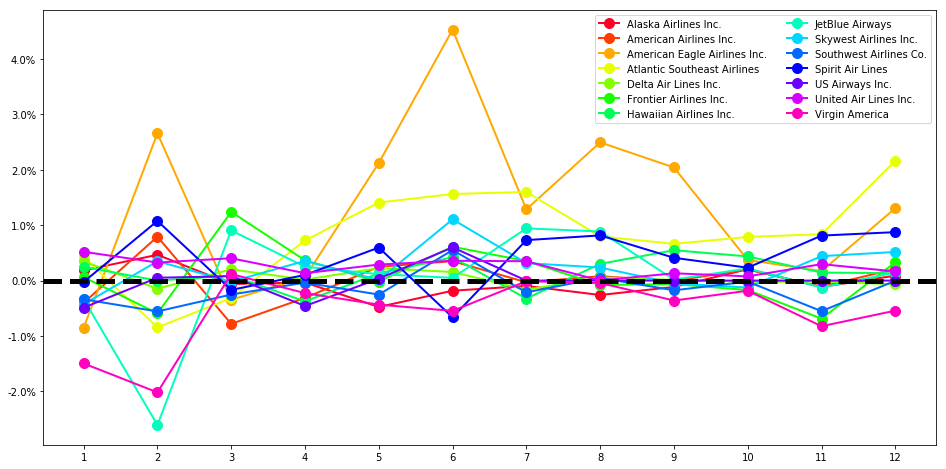

In [52]:
from cycler import cycler
indices2 = np.arange(12)
width2 = np.min(np.diff(indices2))/3
figure, axes = plt.subplots(figsize=(16,8))
axes.set_prop_cycle(color=plt.cm.gist_rainbow(np.linspace(0,1,14)))
for i in (flights_cancel_airline_month_pivot['AIRLINE_y'].unique()):
    axes.plot(pd.Series(indices2),flights_cancel_airline_month_pivot[flights_cancel_airline_month_pivot['AIRLINE_y']==i]['deviation'],marker='.', markersize=20,linewidth=2,label=i)

axes.legend(ncol=2, loc='upper right')
axes.axhline(y=0, xmin=0, xmax=1,color="black",linewidth=5,linestyle='--')
plt.xticks(indices2,flights_cancel_airline_month[(flights_cancel_airline_month['AIRLINE_y']=='JetBlue Airways') & (flights_cancel_airline_month['DE_Period']=='Later')]['MONTH'])
axes.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

I tried to combine the month and airline variable. 

From the visual above, each line represent the deviation between later cancellation rate and earlier cancellation rate for each airline across 12 months. Although it is a little bit rainbow and hard to understand at first, I still want to show it because I think it can give us some insights that we can not tell from other visualizations. 

- We can see that the variance is really high in February, June and December. It means that all airlines are performing differently during these months, some may have higher cancellation rates in the morning flights while others may have high rates in the afternoon. In other words, customers need to make careful airline choices if they really want to avoid cancellations in their trips during these months. 

- Also, we can see the deviation difference among airlines is really small in April and October, which means that customers would tend to get the silimar cancellation rates no matter what airlines they choose. 

- An interesting finding is that American Eagle Airlines Inc. always shows a much higher cancellation rate in the later of a day compared to other airlines. Customers who have emergencies may want to avoid this airline company.

**Conclusion for Question5:** 

The gap of flight cancellation rate between earlier and later in a day depends on the month of the year as well as on the airline. We can see from the above analysis that the gap is larger in some particular months across the year. 

Moreover, some airline companies has higher cancellation rate in the later in a day while others are the opposite. 

Lastly, when combining the month and airline variable together, we can see high variance among airlines in February and June while the cancellation in April is quite condense. We can also see that American Eagle Airlines always has a significantly high cancel rate than others, especially in the later of a day.

## 6. State based analysis: What are the top three states with lowest average flight delay? What are the top three states with highest average flight delay? Come up with qualitative (and/or quantitative) reason for why you think these states are lowest and highest flight delays.

I have two understandings regarding the average flight delay. One is the **average delay rate** and the other one is the **average delay time (minutes)**. So this analysis would be divided into two parts and focuses on different metrics respectively.

### 6.1 Average Delay Rate

#### - Departure

In [17]:
flights3=pd.merge(flights1,airports.set_index('IATA_CODE'),how='left',left_on='ORIGIN_AIRPORT',right_index=True)
flights3=pd.merge(flights3,airports.set_index('IATA_CODE'),how='left',left_on='DESTINATION_AIRPORT',right_index=True)

In [18]:
flights_de_cancel_state = flights3.groupby('STATE_x',as_index=False).agg(
    {'Departure_Delayed':'sum','FLIGHT_NUMBER':'count'}).rename(
    columns={'Departure_Delayed':'Delay','FLIGHT_NUMBER':'Total'})
flights_de_cancel_state['Percentage']=flights_de_cancel_state['Delay']/flights_de_cancel_state['Total']
flights_de_cancel_state_temp = flights3.groupby(['STATE_x','Departure_Delayed'],as_index=False).agg(
    {'DEPARTURE_DELAY':'mean'}).rename(
    columns={'DEPARTURE_DELAY':'Delay_Time'})
flights_de_cancel_state_temp = flights_de_cancel_state_temp[flights_de_cancel_state_temp['Departure_Delayed'] == 1]

flights_de_cancel_state=pd.merge(flights_de_cancel_state,flights_de_cancel_state_temp,how='left',on='STATE_x')
flights_de_cancel_state=flights_de_cancel_state.drop(columns='Departure_Delayed')
flights_de_cancel_state[0:3]

STATE_x   Delay  Total  Percentage  Delay_Time
0      AK  1946.0   6630    0.293514   30.292395
1      AL  1523.0   5277    0.288611   39.764281
2      AR  1331.0   4497    0.295975   46.007513

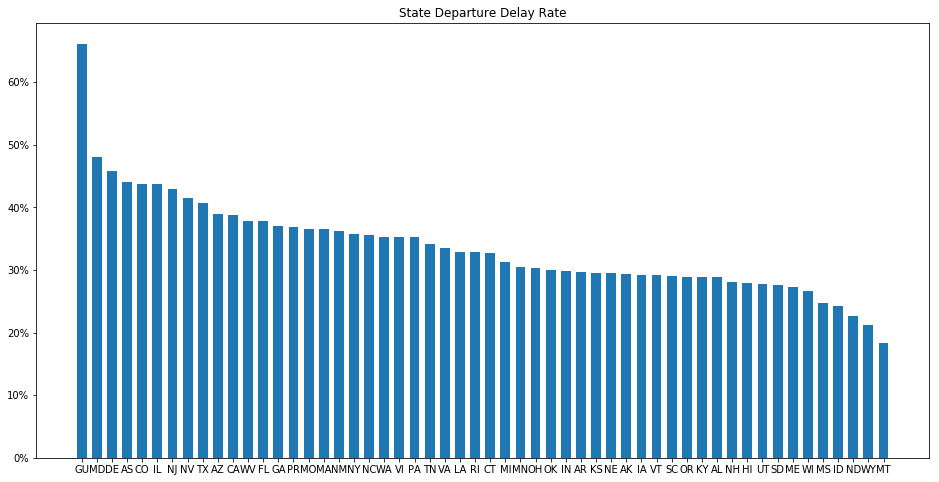

In [54]:
flights_de_cancel_state = flights3.groupby('STATE_x',as_index=False).agg(
    {'Departure_Delayed':'sum','FLIGHT_NUMBER':'count'}).rename(
    columns={'Departure_Delayed':'Delay','FLIGHT_NUMBER':'Total'})
flights_de_cancel_state['Percentage']=flights_de_cancel_state['Delay']/flights_de_cancel_state['Total']
flights_de_cancel_state_temp = flights3.groupby(['STATE_x','Departure_Delayed'],as_index=False).agg(
    {'DEPARTURE_DELAY':'mean'}).rename(
    columns={'DEPARTURE_DELAY':'Delay_Time'})
flights_de_cancel_state_temp = flights_de_cancel_state_temp[flights_de_cancel_state_temp['Departure_Delayed'] == 1]

flights_de_cancel_state=pd.merge(flights_de_cancel_state,flights_de_cancel_state_temp,how='left',on='STATE_x')
flights_de_cancel_state.drop(columns='Departure_Delayed',inplace=True)

flights_de_cancel_state.sort_values('Percentage',ascending = False,inplace=True)


figure, axes = plt.subplots(figsize=(16,8))
axes.bar(flights_de_cancel_state['STATE_x'],flights_de_cancel_state['Percentage'],width=.65)
axes.set_title('State Departure Delay Rate')
axes.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [20]:
flights_de_cancel_state1 = flights_de_cancel_state.copy()
flights_de_cancel_state1['Delay'] = flights_de_cancel_state1['Delay'].astype(int)
flights_de_cancel_state1['Percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in flights_de_cancel_state1['Percentage']], index = flights_de_cancel_state1.index)
flights_de_cancel_state1['Delay_Time'] = pd.Series([round(val, 2) for val in flights_de_cancel_state1['Delay_Time']], index = flights_de_cancel_state1.index)
flights_de_cancel_state1[0:3]

STATE_x  Delay  Total Percentage  Delay_Time
11      GU     41     62     66.13%       17.73
21      MD   8299  17267     48.06%       30.78
8       DE     11     24     45.83%       70.73

In [21]:
flights_de_cancel_state1[-3:]

STATE_x  Delay  Total Percentage  Delay_Time
29      ND    754   3322     22.70%       50.02
53      WY    344   1617     21.27%       39.81
27      MT    559   3047     18.35%       41.27

#### - Arrival

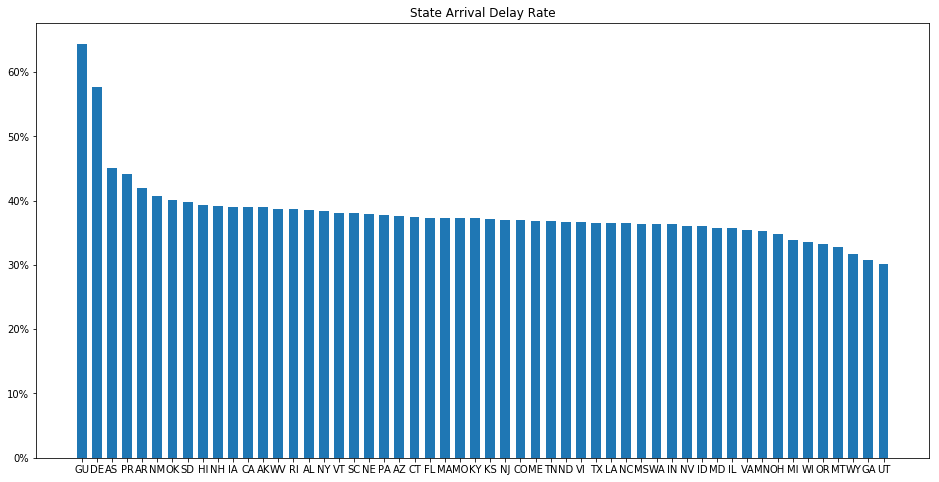

In [22]:
flights_ar_cancel_state = flights3.groupby('STATE_y',as_index=False).agg(
    {'Arrival_Delayed':'sum','FLIGHT_NUMBER':'count'}).rename(
    columns={'Arrival_Delayed':'Delay','FLIGHT_NUMBER':'Total'})
flights_ar_cancel_state['Percentage']=flights_ar_cancel_state['Delay']/flights_ar_cancel_state['Total']
flights_ar_cancel_state_temp = flights3.groupby(['STATE_y','Arrival_Delayed'],as_index=False).agg(
    {'ARRIVAL_DELAY':'mean'}).rename(
    columns={'ARRIVAL_DELAY':'Delay_Time'})
flights_ar_cancel_state_temp = flights_ar_cancel_state_temp[flights_ar_cancel_state_temp['Arrival_Delayed'] == 1]

flights_ar_cancel_state=pd.merge(flights_ar_cancel_state,flights_ar_cancel_state_temp,how='left',on='STATE_y')
flights_ar_cancel_state.drop(columns='Arrival_Delayed',inplace=True)

flights_ar_cancel_state.sort_values('Percentage',ascending = False,inplace=True)


figure, axes = plt.subplots(figsize=(16,8))
axes.bar(flights_ar_cancel_state['STATE_y'],flights_ar_cancel_state['Percentage'],width=.65)
axes.set_title('State Arrival Delay Rate')
axes.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [23]:
flights_ar_cancel_state1 = flights_ar_cancel_state.copy()
flights_ar_cancel_state1['Delay'] = flights_ar_cancel_state1['Delay'].astype(int)#
flights_ar_cancel_state1['Percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in flights_ar_cancel_state1['Percentage']], index = flights_ar_cancel_state1.index)
flights_ar_cancel_state1['Delay_Time'] = pd.Series([round(val, 2) for val in flights_ar_cancel_state1['Delay_Time']], index = flights_ar_cancel_state1.index)
flights_ar_cancel_state1[0:3]

STATE_y  Delay  Total Percentage  Delay_Time
11      GU     38     59     64.41%       30.42
8       DE     15     26     57.69%       48.53
3       AS      9     20     45.00%       15.00

In [24]:
flights_ar_cancel_state1[-3:]

STATE_y  Delay  Total Percentage  Delay_Time
53      WY    502   1585     31.67%       33.21
10      GA  22158  72074     30.74%       35.28
46      UT   5994  19897     30.13%       28.03

**Conclusion: ** 

If you depart from ***GU, MD and DE***, the possibility of departure delay is higher than from any other states. ***MT, WY and ND*** have the lowest average departure delay rate.

As for the arrival delay, landing in ***GU, DE and AS*** would not be a good choice since they are the states that have the highest average arrival delay rate. ***UT, GA and WY*** are good landing choices due to their low average arrival delay rate.

Also, we notice that ***GU*** State has the highest delay rate no matter departure or arrival. The airports in this state may need to be checked to improve the performance.

### 6.2 Average Delay Time

#### - Departure

In [25]:
flights_de_cancel_state1.sort_values('Delay_Time',ascending = False,inplace=True)
flights_de_cancel_state1[0:3]

STATE_x  Delay  Total Percentage  Delay_Time
8       DE     11     24     45.83%       70.73
29      ND    754   3322     22.70%       50.02
49      VT    184    632     29.11%       48.99

In [26]:
flights_de_cancel_state1[-3:]

STATE_x  Delay  Total Percentage  Delay_Time
12      HI   5130  18351     27.95%       22.48
11      GU     41     62     66.13%       17.73
3       AS     11     25     44.00%        7.09

#### - Arrival

In [27]:
flights_ar_cancel_state1.sort_values('Delay_Time',ascending = False,inplace=True)
flights_ar_cancel_state1[0:3]

STATE_y  Delay  Total Percentage  Delay_Time
8       DE     15     26     57.69%       48.53
32      NJ   7988  21627     36.94%       42.67
35      NY  18960  49407     38.38%       40.54

In [28]:
flights_ar_cancel_state1[-3:]

STATE_y  Delay  Total Percentage  Delay_Time
0       AK   2602   6682     38.94%       24.49
12      HI   7209  18317     39.36%       20.62
3       AS      9     20     45.00%       15.00

**Conclusion: ** 

If you depart from ***DE, ND and VT***, the average departure delay time is higher than from any other states. ***HI, GU and AS*** have the lowest average departure delay time.

As for the arrival delay, if a passenger choose to land in ***DE, NJ and NY*** and he/she experienced arrival delay, the extra time he/she needs to wait for is usually longest compared to other states. ***AK, HI and AS*** are good landing choices due to their low average arrival delay time.

An interesting finding here is that, although **GU** State has quite high delay rate, its average time is not very long. However, **DE** State always got on the highest list under both two different metrics (average delay rate & average delay time). The DE State government may want to pay some attention to this situation.

## 7. Taxi time in the flight is most frustrating experience to me. Can you let me know which airports I should avoid and which ones I should prefer? Answer this based on average taxi time (both taxi in and taxi out)?

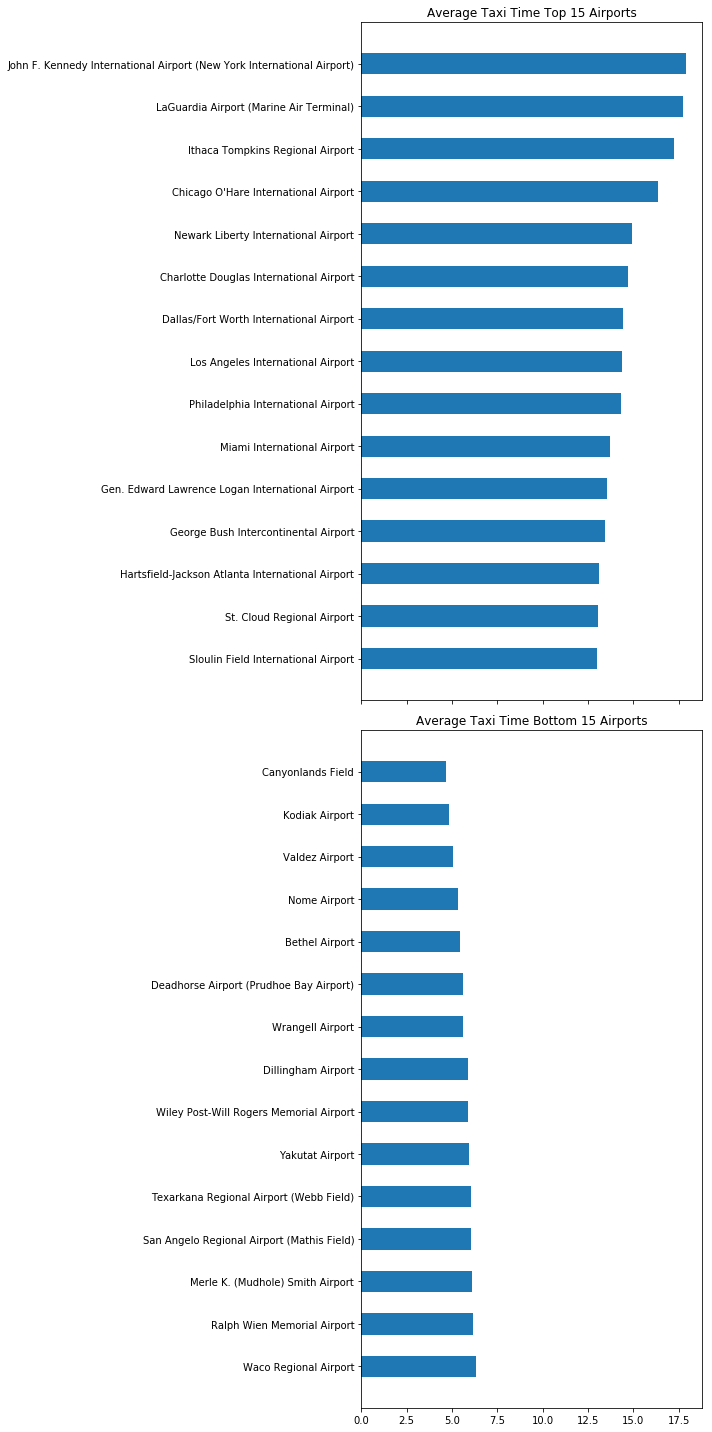

In [29]:
flights_taxi_ori = flights3[['AIRPORT_x','TAXI_OUT']].rename(columns={'AIRPORT_x':'Airport','TAXI_OUT':'TAXI'})
flights_taxi_arr = flights3[['AIRPORT_y','TAXI_IN']].rename(columns={'AIRPORT_y':'Airport','TAXI_IN':'TAXI'})
flights_taxi = pd.concat([flights_taxi_ori, flights_taxi_arr])
flights_taxi = flights_taxi.dropna().groupby('Airport').agg('mean').reset_index().sort_values('TAXI')
flights_taxi_top = flights_taxi.sort_values('TAXI')[-15:]
#flights_taxi_top = flights_taxi.sort_values('TAXI')[-20:]
flights_taxi_btm = flights_taxi.sort_values('TAXI',ascending=False)[-15:]

figure, axes = plt.subplots(2,1,figsize=(10,20),sharex=True)
axes[0].bar(x=0, bottom=flights_taxi_top['Airport'], height=0.5, width=flights_taxi_top['TAXI'], orientation="horizontal")
axes[0].set_title('Average Taxi Time Top 15 Airports')
axes[1].bar(x=0, bottom=flights_taxi_btm['Airport'], height=0.5, width=flights_taxi_btm['TAXI'], orientation="horizontal")
axes[1].set_title('Average Taxi Time Bottom 15 Airports')
plt.tight_layout()

**Recommendations:**

In order to find out the airport with the longest taxi time, I groupped the taxi in and taxi out time in the same airport together and calculated the average taxi time. Then, I came up with the Top15 and the Bottom15 visualization. We can see that the ***New York JFK Airport*** has the longest taxi time among all the airports, and it is followed by the ***LaGuardia Airport*** and ***Ithaca Tompkins Regional Airport***. If you do not want to experience long taxi time, it would be wise choice for you to avoid flights from or to these airports. 

Also, based on the Bottom 15 graph, I would like to recommend the ***Canyonlands Field Airport*** for you because its average taxi time is less than 5 minutes. The ***Kodiak Airport*** and ***Valdez Airport*** are also highly possible to bring you a pleasure flight experience since they rank as 2nd and 3rd for the least taxi time.

## 8. Bonus Point

Based on the analysis above, I would also like to perform some analysis in order to give instructions for choosing flights. I want to know if I have a flexible schedule, what day of week would be the best for me to take a flight and what airline company should I prefer?

### 8.1 What day of week would be the best for me to take a flight that would not be cancelled?

In [30]:
%pprint
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

Pretty printing has been turned OFF


In [61]:
flights_cancel_week = flights2.groupby(['DAY_OF_WEEK','MONTH'],as_index=False).agg(
    {'CANCELLED':'sum','FLIGHT_NUMBER':'count'}).rename(
    columns={'CANCELLED':'Cancelled','FLIGHT_NUMBER':'Total'})
flights_cancel_week['Percentage']=flights_cancel_week['Cancelled']/flights_cancel_week['Total']
flights_cancel_week['Percentage'] = pd.Series([round(val, 5) for val in flights_cancel_week['Percentage']], index = flights_cancel_week.index)

indices3 = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
Months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
data=[]
for i in (flights_cancel_week['MONTH'].unique()):
    i = go.Scatter(
    x=pd.Series(indices3),
    y=flights_cancel_week[flights_cancel_week['MONTH']==i]['Percentage'],
    name=str(Months[i-1])
)
    data.append(i)

plotly.offline.iplot(data)

One thing worth mentioning here is that, since there are so many lines in the visualization, I used the `plotly` package to make it interactive so that we can easily know the detailed information when hovering onto the graph.

- Over the year, the flight cancellation rate on **Wednesdays, Thursdays and Fridays** is generally stable and low while it increases on **Mondays and Sundays**. The lowest flight cancellation rates are usually in weekdays while the maximums are in the weekends. 

- It also delves into the details of each month. We can see that each month has its own peaks, for example, in March there is higher flight cancellation rate during Thursdays while in January the highest cancellation rate is in Tuesdays. Different day-of-week recommendations should give out to different months.

- Moreover, we should pay attention to the line of February. It is quite different from all the other lines. My tuition is that it is caused by holidays or sport events (such as super bowl). Since we now only have data from 2015, we should collect data from more years to see if the trend exists all along the way.

### 8.2 what airline company should I prefer?

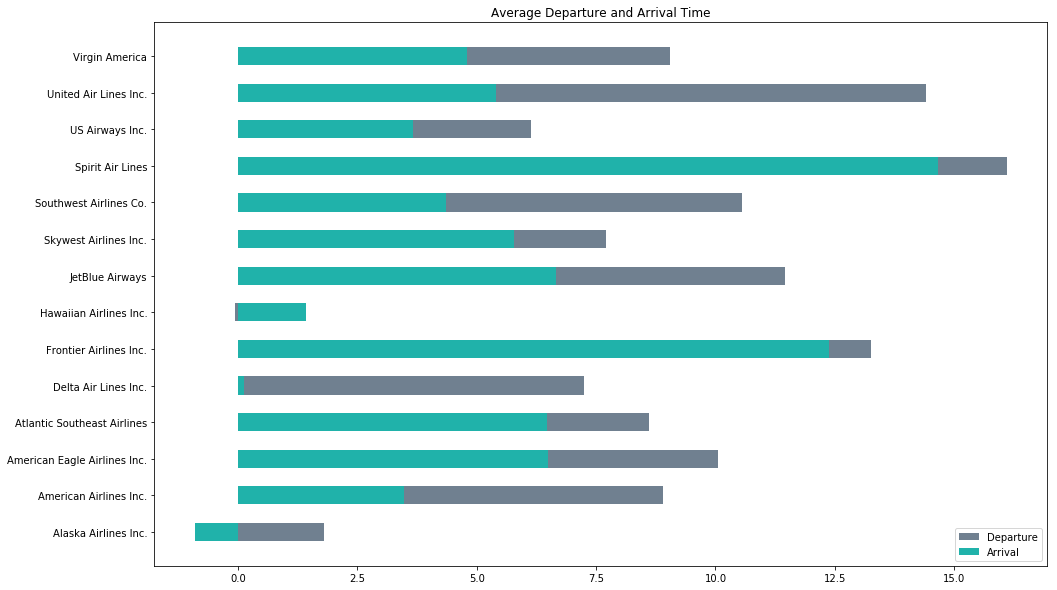

In [33]:
flights_delay_airline = flights2.groupby(['AIRLINE_y'],as_index=False).agg(
    {'DEPARTURE_DELAY':'mean','ARRIVAL_DELAY':'mean'}).rename(
    columns={'DEPARTURE_DELAY':'Depart','ARRIVAL_DELAY':'Arriv'})
flights_delay_airline
figure, axes = plt.subplots(figsize=(16,10))
axes.bar(x=0, bottom=flights_delay_airline['AIRLINE_y'], height=0.5, width=flights_delay_airline['Depart'], orientation="horizontal",label='Departure',color='slategrey')
axes.bar(x=0, bottom=flights_delay_airline['AIRLINE_y'], height=0.5, width=flights_delay_airline['Arriv'], orientation="horizontal",label='Arrival',color='lightseagreen')
axes.set_title('Average Departure and Arrival Time')
axes.legend(ncol=1, loc='lower right')

- Based on this visual, we can see that all the airlines have longer departure delays than arrival delays, except for Hawwaiian Airlines Inc.. My inference is that the flights can adjust speed to catch up time while departure delay sometimes are out of control due to restriction from the airports as well as the air traffic control.

- Spirit Airlines and Frontier Airlines are among the longest arrival and departure delay airlines, we might to avoid this two airlines to avoid high delay time. 

- In addition, it is worth mentioning that Alaska Airlines is the only airline among all to arrive the destination earlier than scheduled in average. I would set Alaska as my top airline choice because it has the capacity to bring me to the destination earlier than I expect.

**Conclusion: **

- **Day of week:** Generally, *Friday* would be the best day of week to fly since the possibility that the flight would get cancelled is very lowest across the year.

- **Airline:** *Alaska Airline* is good at catching up time while Spirit and Frontier Airlines are not.